# Bolt challenge

Importing dependencies

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import zscore,chi2_contingency


Reading the datasets

In [2]:
df_orders = pd.read_csv('orders.csv')
df_order_stages = pd.read_csv('order_stages.csv')

Checking the data of orders dataset.

In [3]:
df_orders.head()

,task_id,order_id,customer_id,restaurant_id,city,restaurant_address_lng,restaurant_address_lat,delivery_address_lng,delivery_address_lat,order_state,order_promised_delivery,restaurant_finished_preparation
0,1,1,15116,721,Bucharest,26.074823,44.415090,26.014888,44.428852,delivered,2021-10-15T03:31:11.000Z,2021-10-15T03:08:44.000Z
1,1,2,12572,1445,Bucharest,26.054794,44.454021,26.093656,44.434069,delivered,2021-10-15T03:46:07.000Z,2021-10-15T03:24:22.000Z
2,1,3,34814,891,Bucharest,26.049776,44.424410,26.020117,44.411906,delivered,2021-10-15T04:00:30.000Z,2021-10-15T03:45:39.000Z
3,1,4,17168,368,Bucharest,26.143047,44.430457,26.126890,44.417530,delivered,2021-10-15T04:15:53.000Z,2021-10-15T04:08:40.000Z
4,1,5,35129,721,Bucharest,26.074823,44.415090,26.030227,44.433221,delivered,2021-10-15T04:44:42.000Z,2021-10-15T04:28:17.000Z


In [4]:
df_orders['city'].unique()

array(['Bucharest'], dtype=object)

In [5]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65584 entries, 0 to 65583
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   task_id                          65584 non-null  int64  
 1   order_id                         65584 non-null  int64  
 2   customer_id                      65584 non-null  int64  
 3   restaurant_id                    65584 non-null  int64  
 4   city                             65584 non-null  object 
 5   restaurant_address_lng           65584 non-null  float64
 6   restaurant_address_lat           65584 non-null  float64
 7   delivery_address_lng             65584 non-null  float64
 8   delivery_address_lat             65584 non-null  float64
 9   order_state                      65584 non-null  object 
 10  order_promised_delivery          65584 non-null  object 
 11  restaurant_finished_preparation  65525 non-null  object 
dtypes: float64(4), int

There are not null values in the dataset. <br>

*Note:* The objects of timestamp are not in datetime and they have 'Z' at the end of the string indicating UTC time.

In [6]:
df_orders.dtypes

task_id                              int64
order_id                             int64
customer_id                          int64
restaurant_id                        int64
city                                object
restaurant_address_lng             float64
restaurant_address_lat             float64
delivery_address_lng               float64
delivery_address_lat               float64
order_state                         object
order_promised_delivery             object
restaurant_finished_preparation     object
dtype: object

## **Working with orders dataset**

### Feature engineering

Here I'll build some new features to help with the analysis and also clean up redundant features.

In [7]:
### Feature engineering

# 1. Creation of distance between restaurant and delivery address

def haversine(lat1, lon1, lat2, lon2):
    """
    Function to calculate the Haversine distance.
    The idea here is to cluster lat/lng features to have a better understanding of the data.
    Calculate the great-circle distance between two points on the Earth (specified in decimal degrees).
    Returns the distance in kilometers.
    """
    # Convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

# Creating a new feature to calculate the distance between restaurant and delivery address.
df_orders['restaurant_delivery_distance'] = haversine(df_orders['restaurant_address_lng'], df_orders['restaurant_address_lat'], df_orders['delivery_address_lng'], df_orders['delivery_address_lat'])

# Removing lat and lng columns
df_orders.drop(columns=['restaurant_address_lat', 'restaurant_address_lng', 'delivery_address_lat', 'delivery_address_lng'], inplace=True)

# 2. Converting order_promised_delivery_time to datetime
df_orders['order_promised_delivery'] = pd.to_datetime(df_orders['order_promised_delivery']).dt.tz_localize(None)

# 3. Converting order_created_at to datetime
df_orders['restaurant_finished_preparation'] = pd.to_datetime(df_orders['restaurant_finished_preparation']).dt.tz_localize(None)

# 4. Diference between order_promised_delivery and restaurant_finished_preparation
df_orders['dif_promised_preparation'] = df_orders['order_promised_delivery'] - df_orders['restaurant_finished_preparation']

# Converting the difference to minutes
df_orders['dif_promised_preparation'] = df_orders['dif_promised_preparation'].dt.total_seconds() / 60

# 5. Extracting weekday from restaurant_finished_preparation
df_orders['weekday'] = df_orders['restaurant_finished_preparation'].dt.day_name()



Now, let's check the data.

I want to transform the order_state column to binary.

In [8]:
df_orders['order_state'] = df_orders['order_state'].replace({'delivered': 1, 'failed': 0})


/var/folders/wr/tth9g68x4pq8xw10b_dqg0qm0000gn/T/ipykernel_39977/218076531.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_orders['order_state'] = df_orders['order_state'].replace({'delivered': 1, 'failed': 0})


Let's see the distribution of the order_state column.

In [9]:
df_orders[['order_id','order_state']].groupby('order_state').count()


,order_id
order_state,
0,111
1,65473


In [10]:
weekday_analysis = (
    df_orders[['weekday','order_state','order_id']].groupby(['weekday','order_state'],as_index=False).count().rename(columns={'order_id':'order_qt'})
)

# Pivot the table to have order_state as columns
weekday_pivot = weekday_analysis.pivot(index='weekday', columns='order_state', values='order_qt').fillna(0)

# Calculate the cancelation rate
weekday_pivot['cancelation_rate'] = weekday_pivot[0] / (weekday_pivot[0] + weekday_pivot[1])

# Drop the order_state columns
weekday_pivot.drop(columns=[0, 1], inplace=True)

# Reset index to make weekday a column again
weekday_pivot.reset_index(inplace=True)

weekday_cancels = weekday_pivot.copy()

weekday_cancels

order_state,weekday,cancelation_rate
0,Friday,0.000968
1,Monday,0.001274
2,Saturday,0.000632
3,Sunday,0.001196
4,Thursday,0.000290
5,Tuesday,0.000325
6,Wednesday,0.000908


In [11]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65584 entries, 0 to 65583
Data columns (total 11 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   task_id                          65584 non-null  int64         
 1   order_id                         65584 non-null  int64         
 2   customer_id                      65584 non-null  int64         
 3   restaurant_id                    65584 non-null  int64         
 4   city                             65584 non-null  object        
 5   order_state                      65584 non-null  int64         
 6   order_promised_delivery          65584 non-null  datetime64[ns]
 7   restaurant_finished_preparation  65525 non-null  datetime64[ns]
 8   restaurant_delivery_distance     65584 non-null  float64       
 9   dif_promised_preparation         65525 non-null  float64       
 10  weekday                          65525 non-null  object   

*Note*: The features are not balanced. This might be a problem for a future model if needed. <br>

At the same time, it shows that the operation may be very efficient. <br>
Now, let's visualize the data.


### Data visualization of orders dataset

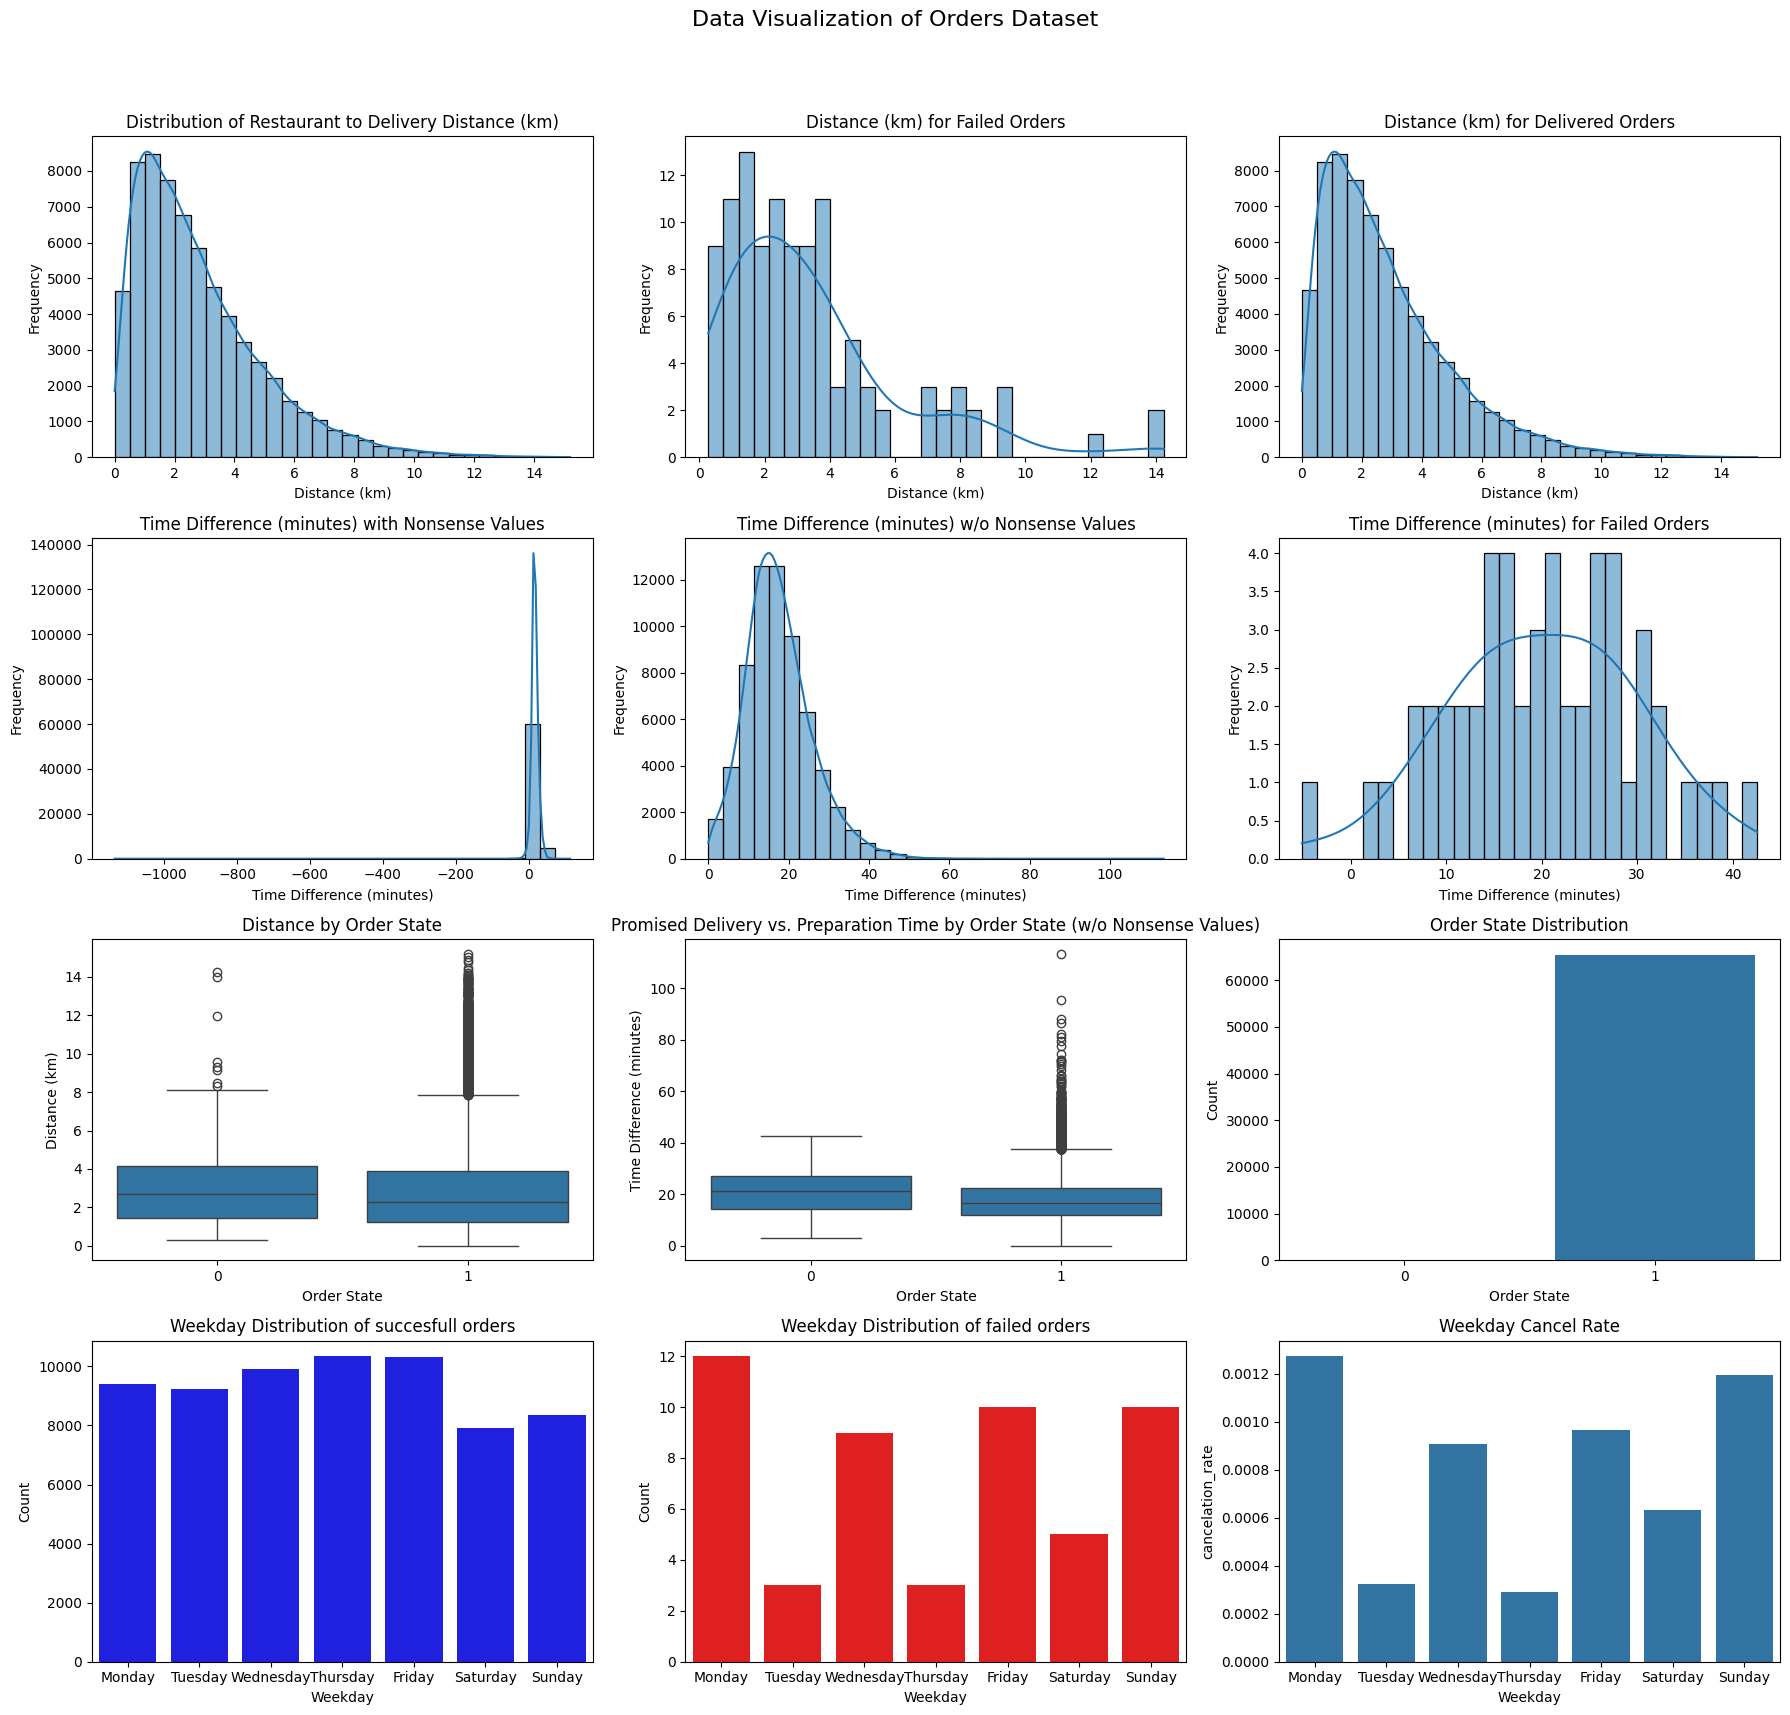

In [12]:
# Data visualization using seaborn in a single grid plot

fig, axes = plt.subplots(4, 3, figsize=(18, 18))
fig.suptitle('Data Visualization of Orders Dataset', fontsize=16)

# 1a. Distribution of restaurant_delivery_distance
sns.histplot(df_orders['restaurant_delivery_distance'], kde=True, bins=30, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Restaurant to Delivery Distance (km)')
axes[0, 0].set_xlabel('Distance (km)')
axes[0, 0].set_ylabel('Frequency')

# 1b. Distribution of restaurant_delivery_distance for failed orders
sns.histplot(df_orders['restaurant_delivery_distance'].loc[df_orders['order_state']==0], kde=True, bins=30, ax=axes[0, 1])
axes[0, 1].set_title('Distance (km) for Failed Orders')
axes[0, 1].set_xlabel('Distance (km)')
axes[0, 1].set_ylabel('Frequency')

# 1c. Distribution of restaurant_delivery_distance for delivered orders
sns.histplot(df_orders['restaurant_delivery_distance'].loc[df_orders['order_state']==1], kde=True, bins=30, ax=axes[0, 2])
axes[0, 2].set_title('Distance (km) for Delivered Orders')
axes[0, 2].set_xlabel('Distance (km)')
axes[0, 2].set_ylabel('Frequency')

# 2a. Difference between promised delivery and preparation time
sns.histplot(df_orders['dif_promised_preparation'], kde=True, bins=30, ax=axes[1, 0])
axes[1, 0].set_title('Time Difference (minutes) with Nonsense Values')
axes[1, 0].set_xlabel('Time Difference (minutes)')
axes[1, 0].set_ylabel('Frequency')

# 2b. Difference between promised delivery and preparation time (without nonsense values)
sns.histplot(df_orders['dif_promised_preparation'].loc[df_orders['dif_promised_preparation'] > 0], kde=True, bins=30, ax=axes[1, 1])
axes[1, 1].set_title('Time Difference (minutes) w/o Nonsense Values')
axes[1, 1].set_xlabel('Time Difference (minutes)')
axes[1, 1].set_ylabel('Frequency')

# 2c. Difference between promised delivery and preparation time for failed orders
sns.histplot(df_orders['dif_promised_preparation'].loc[df_orders['order_state']==0], kde=True, bins=30, ax=axes[1, 2])
axes[1, 2].set_title('Time Difference (minutes) for Failed Orders')
axes[1, 2].set_xlabel('Time Difference (minutes)')
axes[1, 2].set_ylabel('Frequency')

# 3. Boxplot of distance by order state
sns.boxplot(data=df_orders, x='order_state', y='restaurant_delivery_distance', ax=axes[2, 0])
axes[2, 0].set_title('Distance by Order State')
axes[2, 0].set_xlabel('Order State')
axes[2, 0].set_ylabel('Distance (km)')

# 4. Boxplot of time difference by order state without nonsense values
sns.boxplot(data=df_orders.loc[df_orders['dif_promised_preparation'] > 0], x='order_state', y='dif_promised_preparation', ax=axes[2, 1])
axes[2, 1].set_title('Promised Delivery vs. Preparation Time by Order State (w/o Nonsense Values)')
axes[2, 1].set_xlabel('Order State')
axes[2, 1].set_ylabel('Time Difference (minutes)')

# 5. Countplot of order states
sns.countplot(data=df_orders, x='order_state', ax=axes[2, 2])
axes[2, 2].set_title('Order State Distribution')
axes[2, 2].set_xlabel('Order State')
axes[2, 2].set_ylabel('Count')

# 6. Barplot of weekday distribution by order_state

# 6.a Sucesfull orders

# Sorting days of the week for better visualization
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekday_analysis['weekday'] = pd.Categorical(weekday_analysis['weekday'], categories=weekday_order, ordered=True)
weekday_analysis.sort_values('weekday', inplace=True)

sns.barplot(data=weekday_analysis.loc[weekday_analysis['order_state']==1], x='weekday', y='order_qt', color='blue', ax=axes[3,0])
axes[3, 0].set_title('Weekday Distribution of succesfull orders')
axes[3, 0].set_xlabel('Weekday')
axes[3, 0].set_ylabel('Count')

# 6.b Failed orders

sns.barplot(data=weekday_analysis.loc[weekday_analysis['order_state']==0], x='weekday', y='order_qt', color='red', ax=axes[3,1])
axes[3, 1].set_title('Weekday Distribution of failed orders')
axes[3, 1].set_xlabel('Weekday')
axes[3, 1].set_ylabel('Count')

# 7. Barplot of weekday cancelation rate

# Sorting days of the week for better visualization
weekday_cancels['weekday'] = pd.Categorical(weekday_cancels['weekday'], categories=weekday_order, ordered=True)
weekday_cancels.sort_values('weekday',inplace=True)

sns.barplot(data=weekday_cancels, x='weekday', y='cancelation_rate', ax=axes[3,2])
axes[3, 2].set_title('Weekday Cancel Rate')
axes[3, 2].set_xlabel('Weekday')
axes[3, 2].set_ylabel('cancelation_rate')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


***Insights*** <br>

- Generally, orders that were sucesfully delivered were more likely to have a shorter distance and a shorter time difference between promised delivery and preparation. <br>

- The amount of failed orders were not very significant in the dataset.<br>

- There are also some outliers in the dataset that should be investigated.<br>

- Clearlly we have more probability of a cancelation on Monday and Sunday that we must keep attention to. <br>

## **Working with order_stages dataset**

### General analysis

Let's check the data of order_stages dataset.

In [13]:
df_order_stages.head()

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
0,1,Bucharest,1,677,motorbike,order_proposed_to_courier,2021-10-15 03:04:02.000,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30.000,1
1,2,Bucharest,1,677,motorbike,courier_accepts_order,2021-10-15 03:04:12.000,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10.000,1
2,3,Bucharest,1,677,motorbike,courier_arrived_at_restaurant,2021-10-15 03:08:51.000,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36.000,1
3,4,Bucharest,1,677,motorbike,courier_picked_up_order,2021-10-15 03:08:54.000,26.074581,44.414966,NaN,756.0,23.668382,4988.52796,2021-10-15 03:24:39.000,1
4,5,Bucharest,2,1970,motorbike,order_proposed_to_courier,2021-10-15 03:24:02.000,26.040890,44.479828,NaN,NaN,3076.131080,NaN,2021-10-15 03:46:36.000,1


How many different types of order stages do we have?

In [14]:
df_order_stages['order_stage'].unique()

array(['order_proposed_to_courier', 'courier_accepts_order',
       'courier_arrived_at_restaurant', 'courier_picked_up_order',
       'courier_arrived_at_customer', 'courier_delivered_order'],
      dtype=object)

**Note:** We do not have cancellation as an order_stage.

How many different cities do we have?

In [15]:
df_order_stages['city'].unique()

array(['Bucharest'], dtype=object)

As we can see above, the dataset is structured in a way that we can see the stages of each order. If a column is not related with the current stage, it will be NaN. <br>

**Note:** The objects related to timestamp have no 'Z' at the end of the string indicating UTC time, but all the cities are in Europe/Bucharest, I'll assume that the data is in UTC time. <br>

In [16]:
df_order_stages['order_stage_start'] = pd.to_datetime(df_order_stages['order_stage_start'])
df_order_stages['updated_expected_delivery_time'] = pd.to_datetime(df_order_stages['updated_expected_delivery_time'])


In [17]:
df_order_stages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 384937 entries, 0 to 384936
Data columns (total 15 columns):
 #   Column                                          Non-Null Count   Dtype         
---  ------                                          --------------   -----         
 0   log_id                                          384937 non-null  int64         
 1   city                                            384937 non-null  object        
 2   order_id                                        384937 non-null  int64         
 3   courier_id                                      384937 non-null  int64         
 4   vehicle_type                                    384937 non-null  object        
 5   order_stage                                     384937 non-null  object        
 6   order_stage_start                               384937 non-null  datetime64[ns]
 7   courier_location_lng_at_start                   384860 non-null  float64       
 8   courier_location_lat_at_start     

I'm gonna build weekday column based on order_stages dataframe to avoid data loss, and also to get more accurated data based on order_stage = order_proposed_to_courier.

In [18]:
df_start = df_order_stages[['order_id','order_stage_start']].loc[df_order_stages['order_stage']=='order_proposed_to_courier']

df_start['weekday'] = df_start['order_stage_start'].dt.day_name()

df_start.drop(columns=['order_stage_start'],inplace=True)

df_start

,order_id,weekday
0,1,Friday
4,2,Friday
7,3,Friday
15,4,Friday
20,5,Friday
...,...,...
384903,65582,Friday
384907,65575,Friday
384912,65583,Friday
384916,65579,Friday


Dataset has also a lot of nonsense NaN values, so we need to clean it. But first, let's merge the datasets to have a better understanding of the data.

In [19]:
df_merged_order = pd.merge(df_orders[['order_id','restaurant_id','order_state','order_promised_delivery','restaurant_finished_preparation','restaurant_delivery_distance','dif_promised_preparation']], df_order_stages, on='order_id', how='left')
df_merged_order = df_merged_order.merge(df_start,how='left',on='order_id')

# The column task_id does not add any value to the analysis, so we can drop it.
df_merged_order.drop(columns=['task_id'], inplace=True)
df_merged_order.head()

,order_id,restaurant_id,order_state,order_promised_delivery,restaurant_finished_preparation,restaurant_delivery_distance,dif_promised_preparation,log_id,city,courier_id,...,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,weekday
0,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,1.0,Bucharest,677.0,...,order_proposed_to_courier,2021-10-15 03:04:02,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30,Friday
1,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,2.0,Bucharest,677.0,...,courier_accepts_order,2021-10-15 03:04:12,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10,Friday
2,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,3.0,Bucharest,677.0,...,courier_arrived_at_restaurant,2021-10-15 03:08:51,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36,Friday
3,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,4.0,Bucharest,677.0,...,courier_picked_up_order,2021-10-15 03:08:54,26.074581,44.414966,NaN,756.0,23.668382,4988.527960,2021-10-15 03:24:39,Friday
4,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,11.0,Bucharest,677.0,...,courier_arrived_at_customer,2021-10-15 03:38:01,26.015199,44.428529,NaN,NaN,NaN,43.611625,2021-10-15 03:38:01,Friday


Now we can deal with the NaN values.

In [20]:
# Remove rows where all columns are NaN
df_order_staged_cleaned = df_merged_order.dropna(how='all')

# Remove rows with a high proportion of NaN values (e.g., >50%)
threshold = 0.5
df_order_staged_cleaned = df_order_staged_cleaned.dropna(thresh=int(threshold * len(df_order_staged_cleaned.columns)))

#### Feature Engineering

Now, I'm gonna build a metric of average preparation time by restaurant, so I can measure the distances for each order. The idea here is to evaluate if the restaurant is taking longer to prepare food for failed orders.
<br>

*Note:* Not all orders are actually prepared after proposing to courier, some of them could be prepared before finished state. <br>I don't have the info of exactly when the order started. Let's work on that.

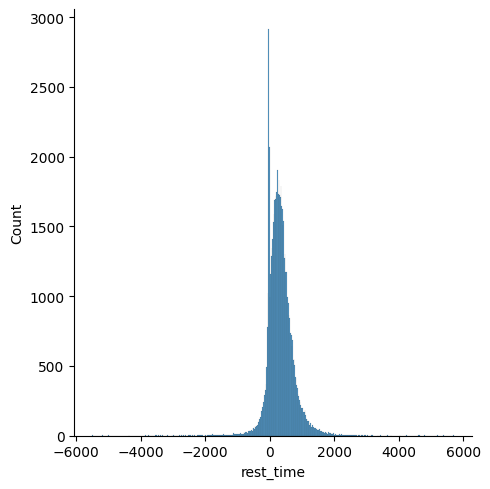

In [21]:
## Feature engineering for order_staged

df_restaurant = df_order_staged_cleaned[['restaurant_id','order_id','order_stage_start','restaurant_finished_preparation']].loc[df_order_staged_cleaned['order_stage'] == 'order_proposed_to_courier']
df_restaurant['rest_time'] = (df_restaurant['restaurant_finished_preparation'] - df_restaurant['order_stage_start']).dt.total_seconds()
df_restaurant.drop(columns=['order_stage_start','restaurant_finished_preparation'],inplace=True)

# df_restaurant.loc[df_restaurant['prep_time']<0]
sns.displot(df_restaurant['rest_time'])

In [22]:
## Feature engineering for order_staged

# Now let's get average rest_time per restaurant

df_rest_avg = df_restaurant[['restaurant_id','rest_time']].groupby('restaurant_id',as_index=False).mean().rename(columns={'rest_time':'avg_rest_time'})

# Now, I'll create a metric of distance from average of rest_time

df_order_restaurants = df_restaurant.merge(df_rest_avg,on='restaurant_id',how='left')

df_order_restaurants['dif_rest_time_avg'] = df_order_restaurants['rest_time'] - df_order_restaurants['avg_rest_time']
df_order_restaurants.drop(columns=['rest_time','avg_rest_time'],inplace=True)

# This is my final metric of distance to avg restaurant time

df_order_restaurants

,restaurant_id,order_id,dif_rest_time_avg
0,721,1,-199.197802
1,1445,2,-303.977528
2,891,3,452.000000
3,368,4,465.525641
4,721,5,333.802198
...,...,...,...
64200,892,65580,-479.859031
64201,22,65581,41.195312
64202,721,65582,568.802198
64203,1071,65583,206.033457


Let's merge to the data

In [23]:
df_order_staged_cleaned = df_order_staged_cleaned.merge(df_order_restaurants, on=['restaurant_id','order_id'],how='left')

Now, we have a metric that brings to table the distance of average in the time (seconds) between order_proposed_to_courier and restaurant_finished_preparation.<br>

This value will repeat at each order_stage. <br>

If it is negative, it means that the restaurant finished the preparation after the order were proposed to courier.
If it is positive, it means that the proposal to courier were made before the order was finished.

#### Checking final database

Let's check some failed orders.

In [24]:
df_order_staged_cleaned.loc[df_order_staged_cleaned['order_state']==0].sort_values(by='order_stage_start', ascending=True).head()

,order_id,restaurant_id,order_state,order_promised_delivery,restaurant_finished_preparation,restaurant_delivery_distance,dif_promised_preparation,log_id,city,courier_id,...,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,weekday,dif_rest_time_avg
450,78,1210,0,2021-10-15 11:27:40,NaT,8.322070,NaN,352.0,Bucharest,378.0,...,2021-10-15 10:48:42,26.089440,44.429962,NaN,NaN,625.495395,NaN,2021-10-15 11:21:13,Friday,NaN
2059,352,1286,0,2021-10-15 12:49:40,2021-10-15 12:37:48,1.393264,11.866667,1652.0,Bucharest,2451.0,...,2021-10-15 12:26:46,26.126643,44.460737,NaN,NaN,490.075698,NaN,2021-10-15 12:45:27,Friday,560.305344
2060,352,1286,0,2021-10-15 12:49:40,2021-10-15 12:37:48,1.393264,11.866667,1658.0,Bucharest,2451.0,...,2021-10-15 12:26:57,26.126463,44.460447,240.0,NaN,456.308062,NaN,2021-10-15 13:02:15,Friday,560.305344
3093,531,1210,0,2021-10-15 13:55:05,2021-10-15 13:27:13,5.060110,27.866667,2791.0,Bucharest,2450.0,...,2021-10-15 13:13:36,26.098520,44.427649,NaN,NaN,671.687532,NaN,2021-10-15 13:46:29,Friday,425.753846
3094,531,1210,0,2021-10-15 13:55:05,2021-10-15 13:27:13,5.060110,27.866667,2793.0,Bucharest,2450.0,...,2021-10-15 13:13:48,26.098557,44.427682,351.0,NaN,669.205692,NaN,2021-10-15 13:46:11,Friday,425.753846


In [25]:
df_order_stages.loc[(df_order_stages['courier_id']==2116) & (df_order_stages['order_id']==64963)].sort_values(by='order_stage_start', ascending=True)

,log_id,city,order_id,courier_id,vehicle_type,order_stage,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,task_id
381029,381030,Bucharest,64963,2116,motorbike,order_proposed_to_courier,2021-11-18 19:24:46,26.127015,44.419622,NaN,NaN,134.452046,NaN,2021-11-18 19:38:26,1
381032,381033,Bucharest,64963,2116,motorbike,courier_accepts_order,2021-11-18 19:24:56,26.127961,44.418749,59.0,NaN,92.464123,NaN,2021-11-18 19:38:06,1
381074,381075,Bucharest,64963,2116,motorbike,courier_arrived_at_restaurant,2021-11-18 19:28:11,26.128483,44.419215,NaN,NaN,26.078152,NaN,NaT,1


So, in order_stages, we cannot clearly understand exactly what happened to the failed order. Was it canceled? Did it had any trouble in delivery process? Let's try to investigate a little further.

### **Some ideas to investigate:** <br>
- **(Distance Analysis)**: Investigate whether distance_courier_to_restaurant_address is significantly higher for failed orders compared to successful ones. <br>
- **(Time related analysis)**: Analyze time differences between stages (e.g., from order_stage_start to updated_expected_delivery_time) to identify delays. <br>
- **(Time related analysis)**: Analyze the distance of the time-related variable (restaurant_finished_preparation - order_proposed_to_courier) from restaurant's average. <br>
    - Evaluate if the distances are different among failures and successes <br>
    - If proved, it means that some restaurants are not being efficients in preparation<br>
- **(Time related analysis)**: Analyze if the expected delivery time is significantly different from order_promised_delivery_time for failed orders. <br>
- **(Courier efficiency)**: Investigate if vehicle type (vehicle_type) influences failure rates.


#### Time related analysis

Here I'll select only variables related to time in the beginning of the order_stages

In [26]:
df_time = df_order_staged_cleaned[['order_id','order_state','order_stage','courier_id','vehicle_type','order_promised_delivery','order_stage_start','restaurant_finished_preparation','updated_expected_delivery_time','dif_rest_time_avg']].loc[df_order_staged_cleaned['order_stage']=='order_proposed_to_courier'].copy()
df_time['order_stage_start'] = pd.to_datetime(df_time['order_stage_start'])
df_time['updated_expected_delivery_time'] = pd.to_datetime(df_time['updated_expected_delivery_time'])


In [27]:
df_time.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64205 entries, 0 to 384931
Data columns (total 10 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   order_id                         64205 non-null  int64         
 1   order_state                      64205 non-null  int64         
 2   order_stage                      64205 non-null  object        
 3   courier_id                       64205 non-null  float64       
 4   vehicle_type                     64205 non-null  object        
 5   order_promised_delivery          64205 non-null  datetime64[ns]
 6   order_stage_start                64205 non-null  datetime64[ns]
 7   restaurant_finished_preparation  64173 non-null  datetime64[ns]
 8   updated_expected_delivery_time   64184 non-null  datetime64[ns]
 9   dif_rest_time_avg                64173 non-null  float64       
dtypes: datetime64[ns](4), float64(2), int64(2), object(2)
memory u

Let's create some features with the comparation between times.

In [28]:
df_time.head()

,order_id,order_state,order_stage,courier_id,vehicle_type,order_promised_delivery,order_stage_start,restaurant_finished_preparation,updated_expected_delivery_time,dif_rest_time_avg
0,1,1,order_proposed_to_courier,677.0,motorbike,2021-10-15 03:31:11,2021-10-15 03:04:02,2021-10-15 03:08:44,2021-10-15 03:27:30,-199.197802
6,2,1,order_proposed_to_courier,1970.0,motorbike,2021-10-15 03:46:07,2021-10-15 03:24:02,2021-10-15 03:24:22,2021-10-15 03:46:36,-303.977528
12,3,1,order_proposed_to_courier,843.0,motorbike,2021-10-15 04:00:30,2021-10-15 03:33:42,2021-10-15 03:45:39,2021-10-15 03:58:33,452.000000
18,4,1,order_proposed_to_courier,2410.0,motorbike,2021-10-15 04:15:53,2021-10-15 03:55:32,2021-10-15 04:08:40,2021-10-15 04:13:18,465.525641
24,5,1,order_proposed_to_courier,2588.0,car,2021-10-15 04:44:42,2021-10-15 04:14:42,2021-10-15 04:28:17,2021-10-15 04:41:12,333.802198


##### Feature engineering

In [29]:
#Difference between promised delivery and expected delivery time (in seconds)
df_time['dif_promised_expected'] = (
    df_time['updated_expected_delivery_time'] - df_time['order_promised_delivery']
).dt.total_seconds()

#Difference between finished preparation and expected delivery time (in seconds)
df_time['dif_finished_expected'] = (
    df_time['updated_expected_delivery_time'] - df_time['restaurant_finished_preparation']
).dt.total_seconds()

#Difference between finished preparation and promised delivery time (in seconds)
df_time['dif_finished_promised'] = (
    df_time['restaurant_finished_preparation'] - df_time['order_promised_delivery']
).dt.total_seconds()

#Difference between order stage start and expected delivery time (in seconds)
df_time['dif_start_expected'] = (
    df_time['order_stage_start'] - df_time['updated_expected_delivery_time']
).dt.total_seconds()

#Difference between order stage start and promised delivery time (in seconds)
df_time['dif_start_promised'] = (
    df_time['order_stage_start'] - df_time['order_promised_delivery']
).dt.total_seconds()

#Difference between order stage start and finished preparation time (in seconds)
df_time['dif_start_finished'] = (
    df_time['order_stage_start'] - df_time['restaurant_finished_preparation']
).dt.total_seconds()

df_time.head()


,order_id,order_state,order_stage,courier_id,vehicle_type,order_promised_delivery,order_stage_start,restaurant_finished_preparation,updated_expected_delivery_time,dif_rest_time_avg,dif_promised_expected,dif_finished_expected,dif_finished_promised,dif_start_expected,dif_start_promised,dif_start_finished
0,1,1,order_proposed_to_courier,677.0,motorbike,2021-10-15 03:31:11,2021-10-15 03:04:02,2021-10-15 03:08:44,2021-10-15 03:27:30,-199.197802,-221.0,1126.0,-1347.0,-1408.0,-1629.0,-282.0
6,2,1,order_proposed_to_courier,1970.0,motorbike,2021-10-15 03:46:07,2021-10-15 03:24:02,2021-10-15 03:24:22,2021-10-15 03:46:36,-303.977528,29.0,1334.0,-1305.0,-1354.0,-1325.0,-20.0
12,3,1,order_proposed_to_courier,843.0,motorbike,2021-10-15 04:00:30,2021-10-15 03:33:42,2021-10-15 03:45:39,2021-10-15 03:58:33,452.000000,-117.0,774.0,-891.0,-1491.0,-1608.0,-717.0
18,4,1,order_proposed_to_courier,2410.0,motorbike,2021-10-15 04:15:53,2021-10-15 03:55:32,2021-10-15 04:08:40,2021-10-15 04:13:18,465.525641,-155.0,278.0,-433.0,-1066.0,-1221.0,-788.0
24,5,1,order_proposed_to_courier,2588.0,car,2021-10-15 04:44:42,2021-10-15 04:14:42,2021-10-15 04:28:17,2021-10-15 04:41:12,333.802198,-210.0,775.0,-985.0,-1590.0,-1800.0,-815.0


**Time-Related Feature Engineering**  
Here are the new time-based features created to analyze delivery performance:  

**<span style="color:red;">dif_promised_expected</span>**  
Measures the gap between when the order was promised to be delivered and our updated delivery estimate.  
**Calculation:**  
{dif\_promised\_expected} = {updated\_expected\_delivery\_time} - {order\_promised\_delivery}
<br>

**<span style="color:red;">dif_finished_expected</span>**  
Measures the time difference between when the restaurant finished preparing the order and the updated delivery estimate.  
**Calculation:**  
{dif\_finished\_expected} = {updated\_expected\_delivery\_time} - {restaurant\_finished\_preparation}
<br>

**<span style="color:red;">dif_finished_promised</span>**  
Measures the time difference between when the restaurant finished preparing the order and the promised delivery time.  
**Calculation:**  
{dif\_finished\_promised} = {restaurant\_finished\_preparation} - {order\_promised\_delivery}
<br>

**<span style="color:red;">dif_start_expected</span>**  
Measures the time difference between when the order was requested by the user and the updated delivery estimate.  
**Calculation:**  
{dif\_start\_expected} = {order\_stage\_start} - {updated\_expected\_delivery\_time}
<br>

**<span style="color:red;">dif_start_promised</span>**  
Measures the time difference between when the order was requested by the user and the promised delivery time.  
**Calculation:**  
{dif\_start\_promised} = {order\_stage\_start} - {order\_promised\_delivery}
<br>

**<span style="color:red;">dif_start_finished</span>**  
Measures the time difference between when the order was requested by the user and when the restaurant finished preparing the order.  
**Calculation:**  
{dif\_start\_finished} = {order\_stage\_start} - {restaurant\_finished\_preparation}
<br>


**Note:** All differences are converted to seconds using .dt.total_seconds()

I'll create a distplot grid to analyze the relationship of the new variables and order_state.

##### Data visualization and hypothesis

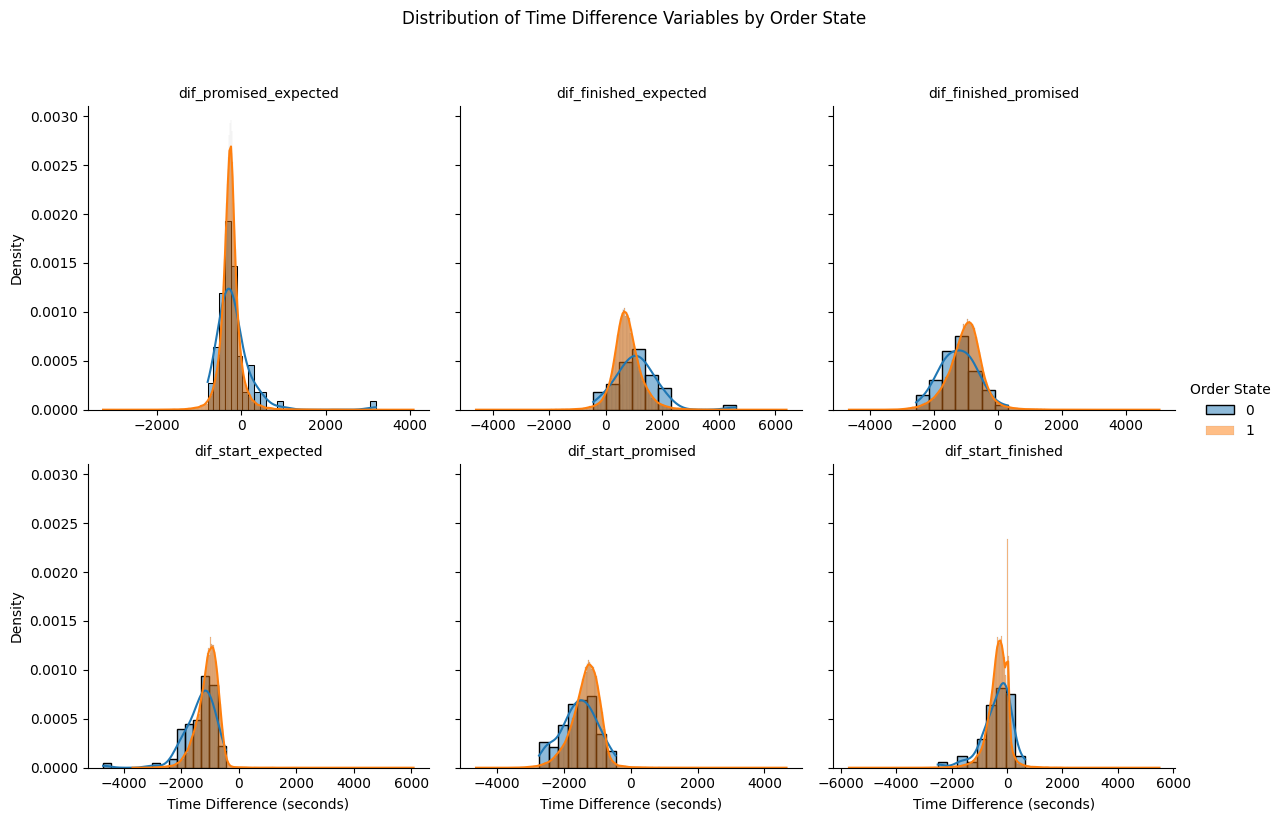

In [30]:
time_diff_vars = [
    'dif_promised_expected',
    'dif_finished_expected',
    'dif_finished_promised',
    'dif_start_expected',
    'dif_start_promised',
    'dif_start_finished'
]

# Create a FacetGrid for distribution plots
g = sns.FacetGrid(df_time.melt(id_vars=['order_state'], value_vars=time_diff_vars), 
                  col='variable', col_wrap=3, hue='order_state', sharex=False, height=4)

# Map the histplot to each facet
g.map(sns.histplot, 'value', kde=True, stat="density")

# Adjust titles and layout
g.set_titles('{col_name}')
g.set_axis_labels('Time Difference (seconds)', 'Density')
g.add_legend(title='Order State')
plt.subplots_adjust(top=0.9)
g.figure.suptitle('Distribution of Time Difference Variables by Order State', y=1.02)

# Show the plot
plt.show()

Now we can see more clearly that non-delivered orders have a slight difference in the distribution of the time difference variables. <br>
Here are some insights: <br>
<br>
Note: The closer to zero, smaller the difference. In this case, means more efficiency in delivery.
<br>
- The difference between promissed delivery and updated expected delivery time is not very significant, both are nearby zero. This indicates that we are promissing closer to updated expected delivery time.
- The difference between finished preparation and updated expected delivery is higher for non-delivered orders, this might indicate that the user may feel frustrated with the delivery time. We will check for significance later.
- The same behavior as above can be seen in finished preparation and promised delivery time.
- The difference between order started and updated delivery time is higher for non-delivery orders.
- Similar behavior as above for promised delivery and order started.
- The difference between finished preparation and order started is similar for both.

##### Restaurant preparation performance

Let's evaluate the created feature of distance from average in terms of rest_time (restaurant_finished_preparation - order_proposed_to_courier)

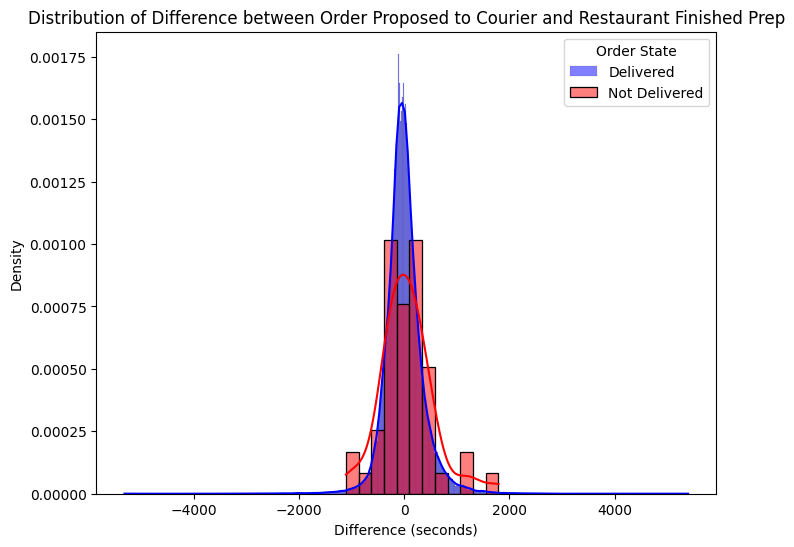

In [31]:
# Filter the data for each order state
delivered = df_time[df_time['order_state'] == 1]['dif_rest_time_avg']
not_delivered = df_time[df_time['order_state'] == 0]['dif_rest_time_avg']

# Create a figure and axis
plt.figure(figsize=(8, 6))

# Plot histograms for each order state
sns.histplot(delivered, kde=True, stat="density", label='Delivered', color='blue')
sns.histplot(not_delivered, kde=True, stat="density", label='Not Delivered', color='red')

# Set titles and labels
plt.title('Distribution of Difference between Order Proposed to Courier and Restaurant Finished Prep')
plt.xlabel('Difference (seconds)')
plt.ylabel('Density')
plt.legend(title='Order State')

# Show the plot
plt.show()

We have a slight difference in the density comparision of delivered and not delivered, let's analyse if this difference is statistically significant as well.

##### Statistical significance

***Let's check for significance.***
Here are some rules:
1. First we'll check if the amount of data is enough to perform the test.
2. If it is, we'll check if the data is normally distributed based on Shapiro-Wilk or Kolmogorov-Smirnov.
3. If it is, we'll use t-test.
4. If it is not, we'll use Mann-Whitney U test.
5. If p-value is greater than 0.05, we'll consider the difference not significant.


In [32]:
from scipy.stats import shapiro, kstest, ttest_ind, mannwhitneyu

def evaluate_statistical_significance(df, target_column):

    """
    In this function I'll evaluate statistical significance of the difference among different target classes.
    Step 1: I'll separate the data into two groups based on order_state (target)
    Step 2: I'll handle cases with insufficient amount of data
    Step 3: I'll check the normality by Shapiro-Wilk and Kolmogorov-Smirnov
    Step 4: I'll determine the test type: if normal behavior -> t-test; if not -> Mann Whitney U test
    Return: dictionary of results
    """

    # Step 1
    delivered = df[df['order_state'] == 1][target_column].dropna()
    not_delivered = df[df['order_state'] != 1][target_column].dropna()
    
    # Step 2
    if len(delivered) < 10 or len(not_delivered) < 10:
        return {
            'Column': target_column,
            'Delivered_Normality_p': None,
            'Not_Delivered_Normality_p': None,
            'Test_Type': 'Insufficient Data',
            'p_value': None
        }
    
    # Step 3
    def check_normality(data):
        """Check normality using Shapiro-Wilk or Kolmogorov-Smirnov based on sample size."""
        if len(data) <= 5000:
            _, p_value = shapiro(data)
        else:
            _, p_value = kstest(data, 'norm')
        return p_value
    
    p_normality_delivered = check_normality(delivered)
    p_normality_not_delivered = check_normality(not_delivered)
    
    # Step 4
    if p_normality_delivered > 0.05 and p_normality_not_delivered > 0.05:
        _, p_value = ttest_ind(delivered, not_delivered, equal_var=False)  # Welch's t-test
        test_type = 't-test'
    else:
        _, p_value = mannwhitneyu(delivered, not_delivered)
        test_type = 'Mann-Whitney U Test'
    
    # Return
    return {
        'Column': target_column,
        'Delivered_Normality_p': p_normality_delivered,
        'Not_Delivered_Normality_p': p_normality_not_delivered,
        'Test_Type': test_type,
        'p_value': p_value
    }



In [33]:
target_columns = [
    'dif_promised_expected', 
    'dif_finished_expected', 
    'dif_finished_promised', 
    'dif_start_expected', 
    'dif_start_promised', 
    'dif_start_finished',
    'dif_rest_time_avg'
]

results = [evaluate_statistical_significance(df_time, col) for col in target_columns]
results_df = pd.DataFrame(results)

pd.DataFrame(results)


,Column,Delivered_Normality_p,Not_Delivered_Normality_p,Test_Type,p_value
0,dif_promised_expected,0.0,1.044151e-12,Mann-Whitney U Test,0.803404
1,dif_finished_expected,0.0,2.366163e-04,Mann-Whitney U Test,0.000312
2,dif_finished_promised,0.0,9.995574e-01,Mann-Whitney U Test,0.004980
3,dif_start_expected,0.0,2.345167e-08,Mann-Whitney U Test,0.000002
4,dif_start_promised,0.0,4.088987e-01,Mann-Whitney U Test,0.000369
5,dif_start_finished,0.0,8.686852e-05,Mann-Whitney U Test,0.751094
6,dif_rest_time_avg,0.0,9.864240e-03,Mann-Whitney U Test,0.536236


**Here are some insights:** <br>
- There are statistical significance in the difference between finished preparation and expected delivery time between delivered and non-delivered orders.
- There are statistical significance in the difference between finished preparation and promised delivery time between delivered and non-delivered orders.
- There are statistical significance in the difference between order started and expected delivery time between delivered and non-delivered orders.
- There are statistical significance in the difference between order started and promised delivery time between delivered and non-delivered orders. <br>

**That means that indeed orders are been promised and updated to be delivered in different pace for non-delivered orders. That can influence the user to trigger order failure by cancellations.**


#### Distance analysis

Here I need to evaluate two moments.
1. The courier distance to the restaurant in the beginning of the journey.
2. The courier distance to the customer after he picked up the order.

In [34]:
df_distances = df_order_staged_cleaned[['order_id','order_state','order_stage','estimated_travel_time_in_seconds_to_restaurant','estimated_travel_time_in_seconds_to_eater','distance_courier_to_restaurant_address','distance_courier_to_customer_address']].loc[df_order_staged_cleaned['order_stage'].isin(['courier_accepts_order', 'courier_picked_up_order'])].fillna(0)
df_distances.head()

,order_id,order_state,order_stage,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address
1,1,1,courier_accepts_order,218.0,0.0,649.953324,0.000000
3,1,1,courier_picked_up_order,0.0,756.0,23.668382,4988.527960
7,2,1,courier_accepts_order,396.0,0.0,2811.287387,0.000000
9,2,1,courier_picked_up_order,0.0,522.0,10.069846,3795.506954
13,3,1,courier_accepts_order,468.0,0.0,2133.587165,0.000000


Now, I'll split the dataset into two different datasets, one for the distance to the restaurant and one for the distance to the customer.

In [35]:
df_distance_rest = df_distances.loc[df_distances['order_stage']=='courier_accepts_order'].drop(columns=['estimated_travel_time_in_seconds_to_eater','distance_courier_to_customer_address'])
df_distance_customer = df_distances.loc[df_distances['order_stage']=='courier_picked_up_order'].drop(columns=['estimated_travel_time_in_seconds_to_restaurant','distance_courier_to_restaurant_address'])

df_distance_rest.head()
# df_distance_customer.head()


,order_id,order_state,order_stage,estimated_travel_time_in_seconds_to_restaurant,distance_courier_to_restaurant_address
1,1,1,courier_accepts_order,218.0,649.953324
7,2,1,courier_accepts_order,396.0,2811.287387
13,3,1,courier_accepts_order,468.0,2133.587165
19,4,1,courier_accepts_order,151.0,516.427225
25,5,1,courier_accepts_order,400.0,2658.265610


Now, ploting the boxplot grid to see the distribution of the distances among the order states.

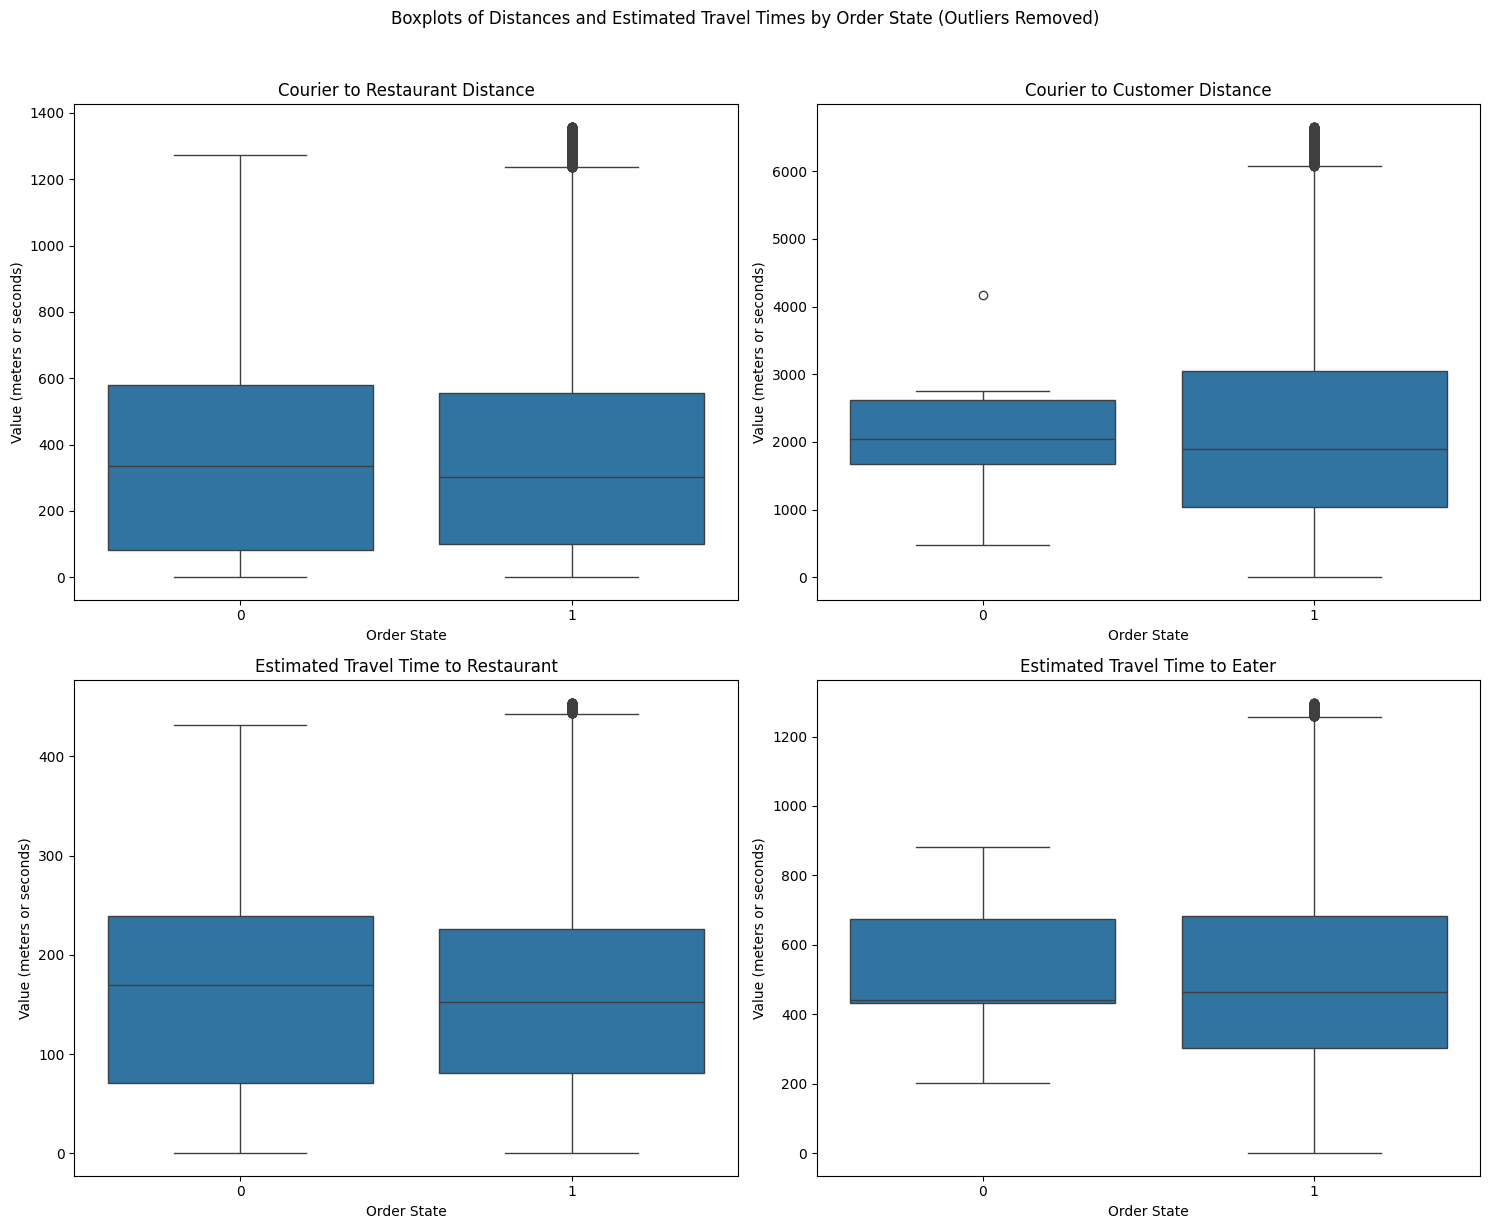

In [36]:

# First, let's remove the outliers to have a better visualization.

def remove_outliers(df, col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Apply outlier removal to the relevant columns
df_distance_rest_filtered = remove_outliers(df_distance_rest, 'distance_courier_to_restaurant_address')
df_distance_customer_filtered = remove_outliers(df_distance_customer, 'distance_courier_to_customer_address')
df_distance_rest_filtered = remove_outliers(df_distance_rest_filtered, 'estimated_travel_time_in_seconds_to_restaurant')
df_distance_customer_filtered = remove_outliers(df_distance_customer_filtered, 'estimated_travel_time_in_seconds_to_eater')

# Define variables for distances and travel times
combined_variables = {
    'Courier to Restaurant Distance': ['df_distance_rest_filtered', 'distance_courier_to_restaurant_address'],
    'Courier to Customer Distance': ['df_distance_customer_filtered', 'distance_courier_to_customer_address'],
    'Estimated Travel Time to Restaurant': ['df_distance_rest_filtered', 'estimated_travel_time_in_seconds_to_restaurant'],
    'Estimated Travel Time to Eater': ['df_distance_customer_filtered', 'estimated_travel_time_in_seconds_to_eater']
}


fig, axes = plt.subplots(2, 2, figsize=(15, 12), sharey=False)

# Loop through the variables and create a boxplot for each
for ax, (title, (df_name, col)) in zip(axes.flatten(), combined_variables.items()):
    df = eval(df_name) 
    sns.boxplot(
        data=df,
        x='order_state',
        y=col,
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel('Order State')
    ax.set_ylabel('Value (meters or seconds)')

plt.suptitle('Boxplots of Distances and Estimated Travel Times by Order State (Outliers Removed)', y=1.02)
plt.tight_layout()
plt.show()


It seems that the courier distance to restaurant is slightly higher for non-delivered orders. Let's evaluate the statistical significance of that difference.

In [37]:
df_distance_customer
# df_distance_rest


,order_id,order_state,order_stage,estimated_travel_time_in_seconds_to_eater,distance_courier_to_customer_address
3,1,1,courier_picked_up_order,756.0,4988.527960
9,2,1,courier_picked_up_order,522.0,3795.506954
15,3,1,courier_picked_up_order,365.0,2690.874188
21,4,1,courier_picked_up_order,327.0,1928.728030
27,5,1,courier_picked_up_order,643.0,4069.547292
...,...,...,...,...,...
384910,65580,1,courier_picked_up_order,191.0,776.256144
384916,65581,1,courier_picked_up_order,135.0,457.789867
384922,65582,1,courier_picked_up_order,740.0,5380.823289
384928,65583,1,courier_picked_up_order,341.0,890.605495


In [38]:
rest_columns = [
    'estimated_travel_time_in_seconds_to_restaurant',
    'distance_courier_to_restaurant_address'
]

customer_columns = [
    'estimated_travel_time_in_seconds_to_eater',
    'distance_courier_to_customer_address'
]

results_customer = [evaluate_statistical_significance(df_distance_customer, col) for col in customer_columns]
results_customer_df = pd.DataFrame(results_customer)

results_rest = [evaluate_statistical_significance(df_distance_rest, col) for col in rest_columns]
results_rest_df = pd.DataFrame(results_rest)



In [39]:
results_customer_df

,Column,Delivered_Normality_p,Not_Delivered_Normality_p,Test_Type,p_value
0,estimated_travel_time_in_seconds_to_eater,0.0,0.134958,Mann-Whitney U Test,0.234394
1,distance_courier_to_customer_address,0.0,0.003190,Mann-Whitney U Test,0.321311


In [40]:
results_rest_df

,Column,Delivered_Normality_p,Not_Delivered_Normality_p,Test_Type,p_value
0,estimated_travel_time_in_seconds_to_restaurant,0.0,5.466244e-02,Mann-Whitney U Test,0.418902
1,distance_courier_to_restaurant_address,0.0,1.915617e-08,Mann-Whitney U Test,0.441763


The results shows that there is no statistical significance in the distance of the courier to the restaurant or the customer in the analysis. <br>
**Distance is not a significant factor for order failure.**


#### Courier efficiency

Here I'll evaluate the efficiency of the courier based on the vehicle type. <br>
We'll also analyse the capacity of keeping food warm during delivery time. <br>

*Note:*<br>
To determine if a categorical variable influences the target, we can use the Chi-Squared test to assess its significance.

In [41]:
df_order_staged_cleaned['vehicle_type'].unique()

array(['motorbike', 'car', 'bicycle'], dtype=object)

In [42]:
df_order_staged_cleaned.head()

,order_id,restaurant_id,order_state,order_promised_delivery,restaurant_finished_preparation,restaurant_delivery_distance,dif_promised_preparation,log_id,city,courier_id,...,order_stage_start,courier_location_lng_at_start,courier_location_lat_at_start,estimated_travel_time_in_seconds_to_restaurant,estimated_travel_time_in_seconds_to_eater,distance_courier_to_restaurant_address,distance_courier_to_customer_address,updated_expected_delivery_time,weekday,dif_rest_time_avg
0,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,1.0,Bucharest,677.0,...,2021-10-15 03:04:02,26.082872,44.416126,NaN,NaN,649.953324,NaN,2021-10-15 03:27:30,Friday,-199.197802
1,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,2.0,Bucharest,677.0,...,2021-10-15 03:04:12,26.082872,44.416126,218.0,NaN,649.953324,NaN,2021-10-15 03:27:10,Friday,-199.197802
2,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,3.0,Bucharest,677.0,...,2021-10-15 03:08:51,26.074600,44.414964,NaN,NaN,22.596096,NaN,2021-10-15 03:26:36,Friday,-199.197802
3,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,4.0,Bucharest,677.0,...,2021-10-15 03:08:54,26.074581,44.414966,NaN,756.0,23.668382,4988.527960,2021-10-15 03:24:39,Friday,-199.197802
4,1,721,1,2021-10-15 03:31:11,2021-10-15 03:08:44,6.804807,22.45,11.0,Bucharest,677.0,...,2021-10-15 03:38:01,26.015199,44.428529,NaN,NaN,NaN,43.611625,2021-10-15 03:38:01,Friday,-199.197802


In [43]:
df_vehicle = df_order_staged_cleaned[['order_id','order_state','vehicle_type']].loc[df_order_staged_cleaned['order_stage']=='order_proposed_to_courier']
df_vehicle.head()

,order_id,order_state,vehicle_type
0,1,1,motorbike
6,2,1,motorbike
12,3,1,motorbike
18,4,1,motorbike
24,5,1,car


In [44]:
df_vehicle[['order_id','vehicle_type']].groupby('vehicle_type').count()

,order_id
vehicle_type,
bicycle,12963
car,5191
motorbike,46051


Now that we just saw the amount of orders by vehicle type, we should evaluate if it's possible that a specific vehicle type could influence the order failure.
Let's break down the problem into two parts:
1. Forumulate a hypothesis to evaluate if the vehicle type could influence the order failure.
2. Perform a chi-square test to evaluate the hypothesis. <br>

<br>

**Null hypothesis:** The vehicle type does not influence the order failure.
**Alternative hypothesis:** The vehicle type influences the order failure.

<br>

Let's perform the chi-square test.

In [45]:
# Contingency table
contingency_table = pd.crosstab(df_vehicle['vehicle_type'], df_vehicle['order_state'])

# chi-squared test
chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-Squared Test Results:")
print(f"Chi2 Statistic: {chi2_stat}")
print(f"P-value: {p_value}")
print(f"Degrees of Freedom: {dof}")

Chi-Squared Test Results:
Chi2 Statistic: 2.8187516682329576
P-value: 0.2442957166284108
Degrees of Freedom: 2


*Based on the chi-squared test:*

We do not have sufficient evidence to conclude that the type of vehicle impacts the likelihood of order failure. <br>
<br>
**This implies that vehicle_type may not play a significant role in determining order success or failure.**

No further analysis is needed for this topic. Vehicle type alone does not influence the order failure.

##### Capacity of delivering it warm

In average food delivery thermal bags could take 20 minutes (assumption).<br>
How many orders are ariving cold?

In [46]:
delivery_time = df_order_staged_cleaned[['order_id','estimated_travel_time_in_seconds_to_eater']].dropna().reset_index(drop=True)
delivery_time['warm_status'] = delivery_time['estimated_travel_time_in_seconds_to_eater'] < 1200
delivery_time.groupby('warm_status',as_index=False).size().rename(columns={'size':'count_rows'})

,warm_status,count_rows
0,False,3504
1,True,60569


### **So far we concluted that:** <br>
- **(Distance Analysis)**: Distance is not a significantly different between failuer and success. <br>
- **(Time related analysis)**: There is statistical significance to asume that time is a significantly different between failure and success. <br>
- **(Courier efficiency)**: Vehicle type alone does not influence the order failure. <br>

But, can the agregation of the variables be a significant factor for order failure? <br>
Let's mess time with vehicle type and evaluate the statistical significance. <br>

**Note:**<br>
When analyzing interactions between multiple variables, ANOVA (Analysis of Variance) is an appropriate statistical method to evaluate whether combinations of variables significantly impact the target variable.


In [47]:
#We already have vehicle type in the df_time, so we can just work with that.

df_time.head()


,order_id,order_state,order_stage,courier_id,vehicle_type,order_promised_delivery,order_stage_start,restaurant_finished_preparation,updated_expected_delivery_time,dif_rest_time_avg,dif_promised_expected,dif_finished_expected,dif_finished_promised,dif_start_expected,dif_start_promised,dif_start_finished
0,1,1,order_proposed_to_courier,677.0,motorbike,2021-10-15 03:31:11,2021-10-15 03:04:02,2021-10-15 03:08:44,2021-10-15 03:27:30,-199.197802,-221.0,1126.0,-1347.0,-1408.0,-1629.0,-282.0
6,2,1,order_proposed_to_courier,1970.0,motorbike,2021-10-15 03:46:07,2021-10-15 03:24:02,2021-10-15 03:24:22,2021-10-15 03:46:36,-303.977528,29.0,1334.0,-1305.0,-1354.0,-1325.0,-20.0
12,3,1,order_proposed_to_courier,843.0,motorbike,2021-10-15 04:00:30,2021-10-15 03:33:42,2021-10-15 03:45:39,2021-10-15 03:58:33,452.000000,-117.0,774.0,-891.0,-1491.0,-1608.0,-717.0
18,4,1,order_proposed_to_courier,2410.0,motorbike,2021-10-15 04:15:53,2021-10-15 03:55:32,2021-10-15 04:08:40,2021-10-15 04:13:18,465.525641,-155.0,278.0,-433.0,-1066.0,-1221.0,-788.0
24,5,1,order_proposed_to_courier,2588.0,car,2021-10-15 04:44:42,2021-10-15 04:14:42,2021-10-15 04:28:17,2021-10-15 04:41:12,333.802198,-210.0,775.0,-985.0,-1590.0,-1800.0,-815.0


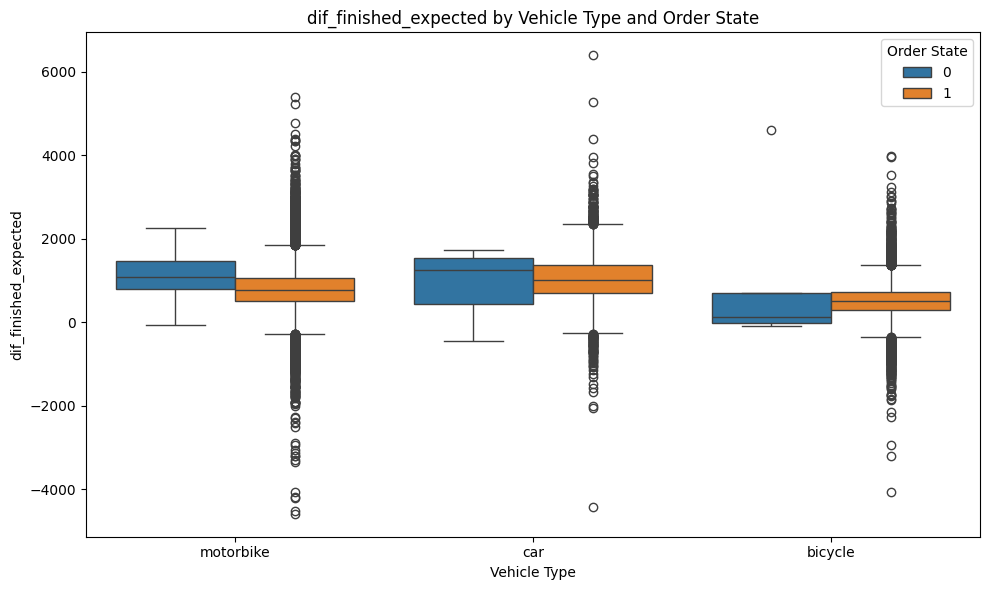

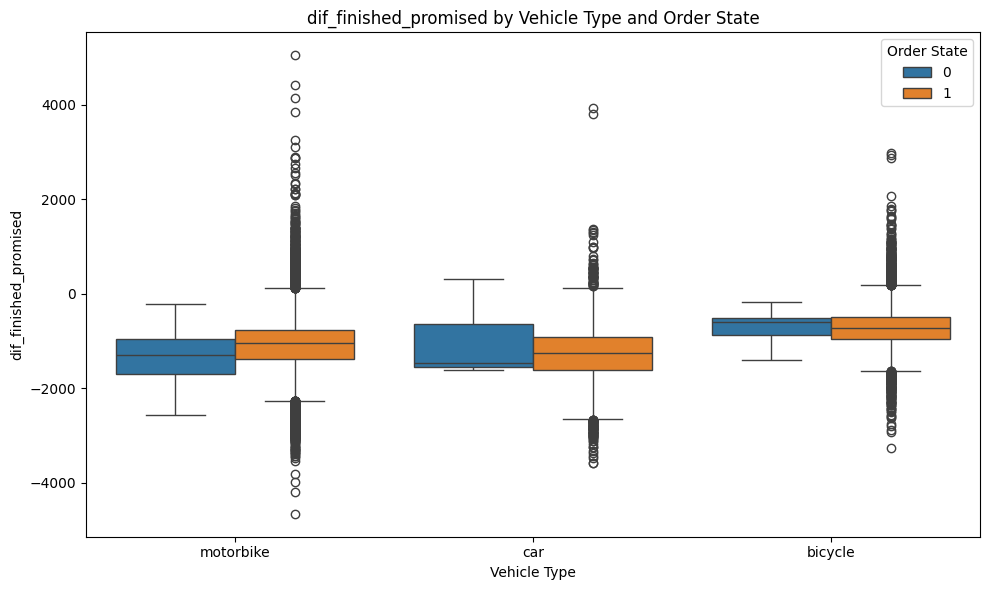

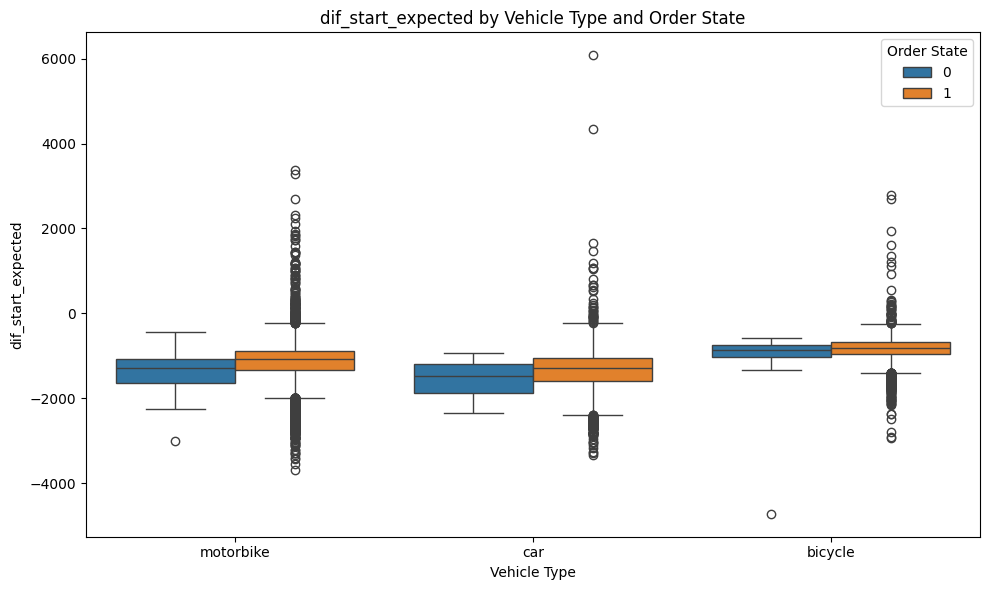

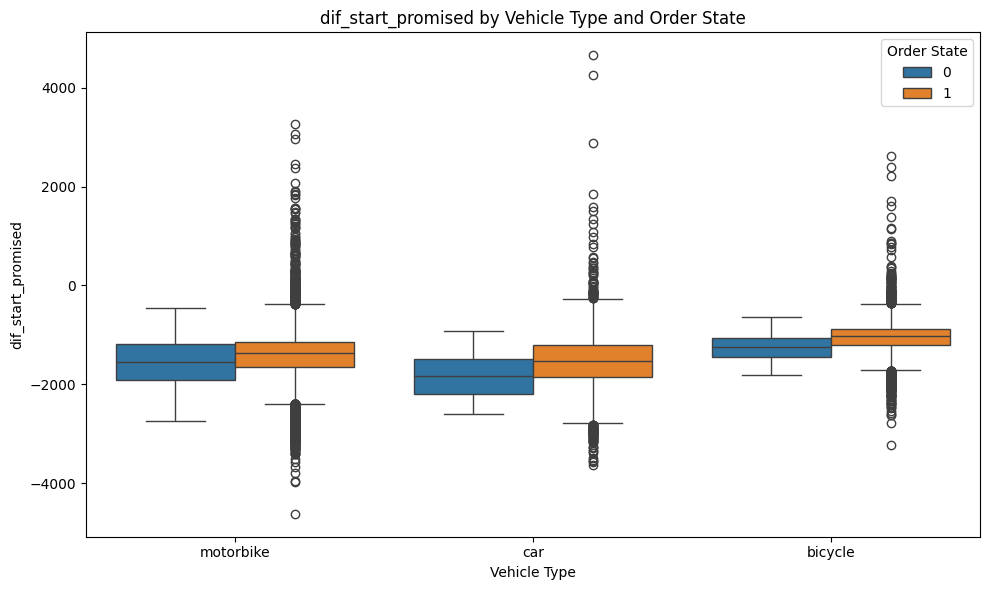

In [48]:
time_related_vars = ['dif_finished_expected', 'dif_finished_promised', 'dif_start_expected','dif_start_promised']

# Creating boxplots for each variable
for var in time_related_vars:
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_time, x='vehicle_type', y=var, hue='order_state')
    plt.title(f'{var} by Vehicle Type and Order State')
    plt.xlabel('Vehicle Type')
    plt.ylabel(var)
    plt.legend(title='Order State', loc='upper right')
    plt.tight_layout()
    plt.show()

Using two-way ANOVA, we can evaluate the statistical significance of the interaction between vehicle type and time related variables.

Hypothesis
Null Hypothesis: The combination of vehicle type and time-related variables does not significantly impact cancellations. <br>
​
Alternative Hypothesis: Certain combinations of vehicle type and time-related variables increase the likelihood of cancellations.

In [49]:
df_time.columns

Index(['order_id', 'order_state', 'order_stage', 'courier_id', 'vehicle_type',
       'order_promised_delivery', 'order_stage_start',
       'restaurant_finished_preparation', 'updated_expected_delivery_time',
       'dif_rest_time_avg', 'dif_promised_expected', 'dif_finished_expected',
       'dif_finished_promised', 'dif_start_expected', 'dif_start_promised',
       'dif_start_finished'],
      dtype='object')

In [50]:
import pandas as pd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm


anovas = []

# Two-way ANOVA for interaction effects
for var in time_related_vars:
    """
    Explaining formula:
    1. order_state - The target variable
    2. {var} - time-related variable
    3. ~ - Means "is modeled as a function of"
    4. C(vehicle_type) - Categorical variable for vehicle type (C() tells that this is categorical)
    5. + - Adds another term to the model
    6. C(vehicle_type):{var} - This evaluates the interaction of both

    We are aiming to determine if vehicle type and time-related variables independently affects order_state, 
    and if their combination has any special effects on it.
    """

    formula = f'order_state ~ C(vehicle_type) + {var} + C(vehicle_type):{var}'
    
    # Fit the model
    model = ols(formula, data=df_time).fit()
    
    # Perform ANOVA
    anova_results = anova_lm(model)
    
    df_results = anova_results.reset_index()
    df_results['variable'] = var
    anovas.append(df_results)

# Combineing results
final_anovas = pd.concat(anovas, ignore_index=True)
final_anovas = final_anovas[['variable', 'index', 'sum_sq', 'df', 'F', 'PR(>F)']]

interaction_effects = final_anovas[final_anovas['index'].str.contains(':')]


print("Interaction Effects:")
interaction_effects


Interaction Effects:


,variable,index,sum_sq,df,F,PR(>F)
2,dif_finished_expected,C(vehicle_type):dif_finished_expected,0.003517,2.0,2.305059,0.099761
6,dif_finished_promised,C(vehicle_type):dif_finished_promised,0.004485,2.0,2.939794,0.052884
10,dif_start_expected,C(vehicle_type):dif_start_expected,0.006974,2.0,2.838354,0.058529
14,dif_start_promised,C(vehicle_type):dif_start_promised,0.000970,2.0,0.385096,0.680387


**Interaction Effects Results**
1. C(vehicle_type):dif_finished_expected <font color='red'>*(Delivery time)*</font> <br>
    **F = 2.305, p = 0.099** <br>
    The interaction is not statistically significant (p > 0.05).
    There's weak evidence that the relationship between vehicle_type and dif_finished_expected affects order_state, but it's not strong enough to conclude.<br>

2. C(vehicle_type):dif_finished_promised <font color='red'>*(Promised delivery time)*</font> <br>
    **F = 2.940, p = 0.053** <br>
    The interaction is marginally significant (just above the 0.05 threshold).
    This suggests there might be a relationship between vehicle_type and dif_finished_promised impacting order_state, but it’s not conclusive. <br>

3. C(vehicle_type):dif_start_expected <font color='red'>*(Order total time)*</font> <br>
    **F = 2.838, p = 0.059** <br>
    Again, marginally significant (p > 0.05 but close).
    Similar to the above, it hints at some association but isn’t strong enough for a solid conclusion.<br>

4. C(vehicle_type):dif_start_promised <font color='red'>*(Promised order total time)*</font> <br>
    **F = 0.385, p = 0.680** <br>
    The interaction is definitely not significant.
    No evidence that the combination of vehicle_type and dif_start_promised impacts order_state.
    Straight-Up Summary
    None of the interactions are strongly significant.
    dif_finished_promised and dif_start_expected are borderline (p-values just above 0.05). These might be worth investigating further with larger datasets or more refined models.
    The other interactions (dif_finished_expected and dif_start_promised) don’t seem to matter at all.

Even in association with time-related variables, vehicle time don't seem to be strongly influencing order_state, only marginally in some cases.
Although it could be a variable for future model training.

## **Machine Learning Model attempt for order_status prediction**

Since we already selected the features that are statistically significant for the order failure, we can now proceed to the model creation.

Dependencies

In [51]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score

In [52]:
df_time

,order_id,order_state,order_stage,courier_id,vehicle_type,order_promised_delivery,order_stage_start,restaurant_finished_preparation,updated_expected_delivery_time,dif_rest_time_avg,dif_promised_expected,dif_finished_expected,dif_finished_promised,dif_start_expected,dif_start_promised,dif_start_finished
0,1,1,order_proposed_to_courier,677.0,motorbike,2021-10-15 03:31:11,2021-10-15 03:04:02,2021-10-15 03:08:44,2021-10-15 03:27:30,-199.197802,-221.0,1126.0,-1347.0,-1408.0,-1629.0,-282.0
6,2,1,order_proposed_to_courier,1970.0,motorbike,2021-10-15 03:46:07,2021-10-15 03:24:02,2021-10-15 03:24:22,2021-10-15 03:46:36,-303.977528,29.0,1334.0,-1305.0,-1354.0,-1325.0,-20.0
12,3,1,order_proposed_to_courier,843.0,motorbike,2021-10-15 04:00:30,2021-10-15 03:33:42,2021-10-15 03:45:39,2021-10-15 03:58:33,452.000000,-117.0,774.0,-891.0,-1491.0,-1608.0,-717.0
18,4,1,order_proposed_to_courier,2410.0,motorbike,2021-10-15 04:15:53,2021-10-15 03:55:32,2021-10-15 04:08:40,2021-10-15 04:13:18,465.525641,-155.0,278.0,-433.0,-1066.0,-1221.0,-788.0
24,5,1,order_proposed_to_courier,2588.0,car,2021-10-15 04:44:42,2021-10-15 04:14:42,2021-10-15 04:28:17,2021-10-15 04:41:12,333.802198,-210.0,775.0,-985.0,-1590.0,-1800.0,-815.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
384907,65580,1,order_proposed_to_courier,1216.0,motorbike,2021-11-19 02:36:13,2021-11-19 02:24:56,2021-11-19 02:22:51,2021-11-19 02:42:18,-479.859031,365.0,1167.0,-802.0,-1042.0,-677.0,125.0
384913,65581,1,order_proposed_to_courier,1422.0,car,2021-11-19 02:36:22,2021-11-19 02:21:56,2021-11-19 02:27:23,2021-11-19 02:33:56,41.195312,-146.0,393.0,-539.0,-720.0,-866.0,-327.0
384919,65582,1,order_proposed_to_courier,960.0,motorbike,2021-11-19 03:07:37,2021-11-19 02:36:56,2021-11-19 02:54:26,2021-11-19 03:03:58,568.802198,-219.0,572.0,-791.0,-1622.0,-1841.0,-1050.0
384925,65583,1,order_proposed_to_courier,1779.0,motorbike,2021-11-19 03:05:40,2021-11-19 02:48:26,2021-11-19 02:57:50,2021-11-19 03:01:00,206.033457,-280.0,190.0,-470.0,-754.0,-1034.0,-564.0


In [53]:
pd.set_option('display.max_columns', 100)

df_model = df_order_staged_cleaned.loc[df_order_staged_cleaned['order_stage']=='order_proposed_to_courier'].merge(df_time,how='left',on='order_id')
df_model = df_model[['restaurant_delivery_distance','vehicle_type_x','distance_courier_to_restaurant_address','weekday','dif_start_promised','dif_start_expected','order_state_x']].dropna()
df_model.rename(columns={'vehicle_type_x':'vehicle_type','order_state_x':'order_state'},inplace=True)

# this will be my baseline dataframe based on the investigation made
df_model

,restaurant_delivery_distance,vehicle_type,distance_courier_to_restaurant_address,weekday,dif_start_promised,dif_start_expected,order_state
0,6.804807,motorbike,649.953324,Friday,-1629.0,-1408.0,1
1,4.758612,motorbike,3076.131080,Friday,-1325.0,-1354.0,1
2,3.526625,motorbike,2132.412445,Friday,-1608.0,-1491.0,1
3,2.212003,motorbike,542.873720,Friday,-1221.0,-1066.0,1
4,5.279273,car,2658.265610,Friday,-1800.0,-1590.0,1
...,...,...,...,...,...,...,...
64200,1.039099,motorbike,2308.561479,Friday,-677.0,-1042.0,1
64201,0.506065,car,948.187071,Friday,-866.0,-720.0,1
64202,7.194758,motorbike,948.476000,Friday,-1841.0,-1622.0,1
64203,1.198424,motorbike,5.430879,Friday,-1034.0,-754.0,1


In [54]:
# df_model[df_model.isna().any(axis=1)]

In [55]:
df_model.groupby('order_state',as_index=False).size().rename(columns={'size':'count_rows'})

,order_state,count_rows
0,0,79
1,1,64105


Data preparation: <br>

- Converting categorical variables into One-Hot Encoding
- Feature Scaling: keeping all the other variables into the same scale.

In [56]:
categorical_features = ['vehicle_type', 'weekday']
numerical_features = ['restaurant_delivery_distance', 'distance_courier_to_restaurant_address', 
                      'dif_start_promised', 'dif_start_expected']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)


Train/test split

In [57]:
X = df_model.drop(columns=['order_state'])
y = df_model['order_state']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Using stratify due to preserve class balance



Model constructor

In [58]:
# I'll be using random forest as baseline

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight='balanced', random_state=42)) #balanced parameter should help assign better weights to minority class.
])

Model training

In [59]:
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['restaurant_delivery_distance',
                                                   'distance_courier_to_restaurant_address',
                                                   'dif_start_promised',
                                                   'dif_start_expected']),
                                                 ('cat',
                                                  OneHotEncoder(drop='first'),
                                                  ['vehicle_type',
                                                   'weekday'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        random_state=42))])

Evaluation

In [60]:
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probability of failure

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        24
           1       1.00      1.00      1.00     19232

    accuracy                           1.00     19256
   macro avg       0.50      0.50      0.50     19256
weighted avg       1.00      1.00      1.00     19256

ROC-AUC Score: 0.5120751438574598


/opt/miniconda3/envs/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/envs/mba/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


**Key Takeaways:**

- The model is heavily biased towards predicting delivered orders (Class 1), leading to being unable to predict one of the classes (Class 0).  
- This bias stems from the severe class imbalance in the dataset (79 failed orders vs. 64,105 delivered orders).  
- Techniques like SMOTE, Oversampling, and Undersampling are insufficient to address this level of imbalance due to the extremely limited data for failed orders.
- Without additional data for failed orders, the model cannot reliably predict the probability of failure, making it unsuitable for production use in its current state.  
- Future improvements should focus on collecting more data for failed orders to better train the model and reduce the class imbalance.  



### **Conclusions**

We were able to statistically evaluate some behaviors throught the data and we could address were able to answer some questions. <br>
- *There is indeed a difference in the time-related variables among failed and delivered orders, as statistically proven.*
- *There is no evidence that the type of vehicle impacts the order state.*
- *There is no evidence that restaurants with failed orders take longer to prepare food.*
- *The distance from the courier to the delivery location or the restaurant is not statistically different between failed and delivered orders.* <br>
- *There is a clear impact of Mondays and Sundays on the failure of orders.*

To address the business problem, we could think about developing a machine learning model to estimate the probability of failure in the begining of an order, right after the courier recieves the proposal - based on type of vehicle, distance, past time-related values and weekday.<br>
But the imbalancement of the data avoid us from getting reliable results. <br>

*Next steps:*<br>
- Collect more data on failed orders, including details about the point at which they fail.
- Gather more information about the order itself (e.g., cuisine type, order request time, order value, etc.).
- Obtain data on customer behavior as well (e.g., what happens to customers whose orders fail? What are their churn rates?).
- After all previous steps, we could develop a model to give us a probability of failure of an order, and with this model in production we could address business decisions on those kinds of orders.


## **Machine Learning Model attempt for prediction of delivery within 20 minutes**

Here we are going to try to predict the probability of this order to arrive warm and tasty for the client.<br>

***Note:*** I made an assumption of max of 20 minutes of arrival to avoid food to being cold.

In [70]:
# Creating the dataframe baseline to the model

df_delivery = df_order_staged_cleaned.loc[df_order_staged_cleaned['order_stage']=='courier_picked_up_order']
df_delivery = df_delivery.merge(df_time[['order_id','dif_start_promised','dif_start_expected']],how='left',on='order_id')
df_delivery = df_delivery[['restaurant_delivery_distance','vehicle_type','weekday','dif_start_promised','dif_start_expected','estimated_travel_time_in_seconds_to_eater']]
df_delivery['warm_status'] = df_delivery['estimated_travel_time_in_seconds_to_eater'] < 1200

#Avoiding target leakage and overfitting
df_delivery.drop(columns=['estimated_travel_time_in_seconds_to_eater'],inplace=True)

In [71]:
categorical_features = ['vehicle_type', 'weekday']
numerical_features = ['restaurant_delivery_distance',
                      'dif_start_promised', 'dif_start_expected']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

In [72]:
X = df_delivery.drop(columns=['warm_status'])
y = df_delivery['warm_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y) # Using stratify due to preserve class balance


In [73]:
delivery_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42))
])

In [74]:
delivery_model.fit(X_train, y_train)

y_pred = delivery_model.predict(X_test)
y_proba = delivery_model.predict_proba(X_test)[:, 1]  # Probability of failure

print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.62      0.70      1070
        True       0.98      0.99      0.98     18171

    accuracy                           0.97     19241
   macro avg       0.89      0.81      0.84     19241
weighted avg       0.97      0.97      0.97     19241

ROC-AUC Score: 0.9803554446671471


The variables following variables showed up to be good predictors for predicting if an order might arrive in 20 minutes or less: 'vehicle_type', 'weekday', 'restaurant_delivery_distance','dif_start_promised', 'dif_start_expected' <br>

That could be a good predictor to avoid cancelations and also enhance user experience.